Starting HD windows time step [days]: [76.75531476628743]
HD windows duration [days]: [<Quantity 7.32524252 d>]
t_wait = 6631659.195807233s
t_hd = 632900.9537629643s
Timestep 864.0000 ss
Run time 1123.56s/18.73m
51.3906050255037


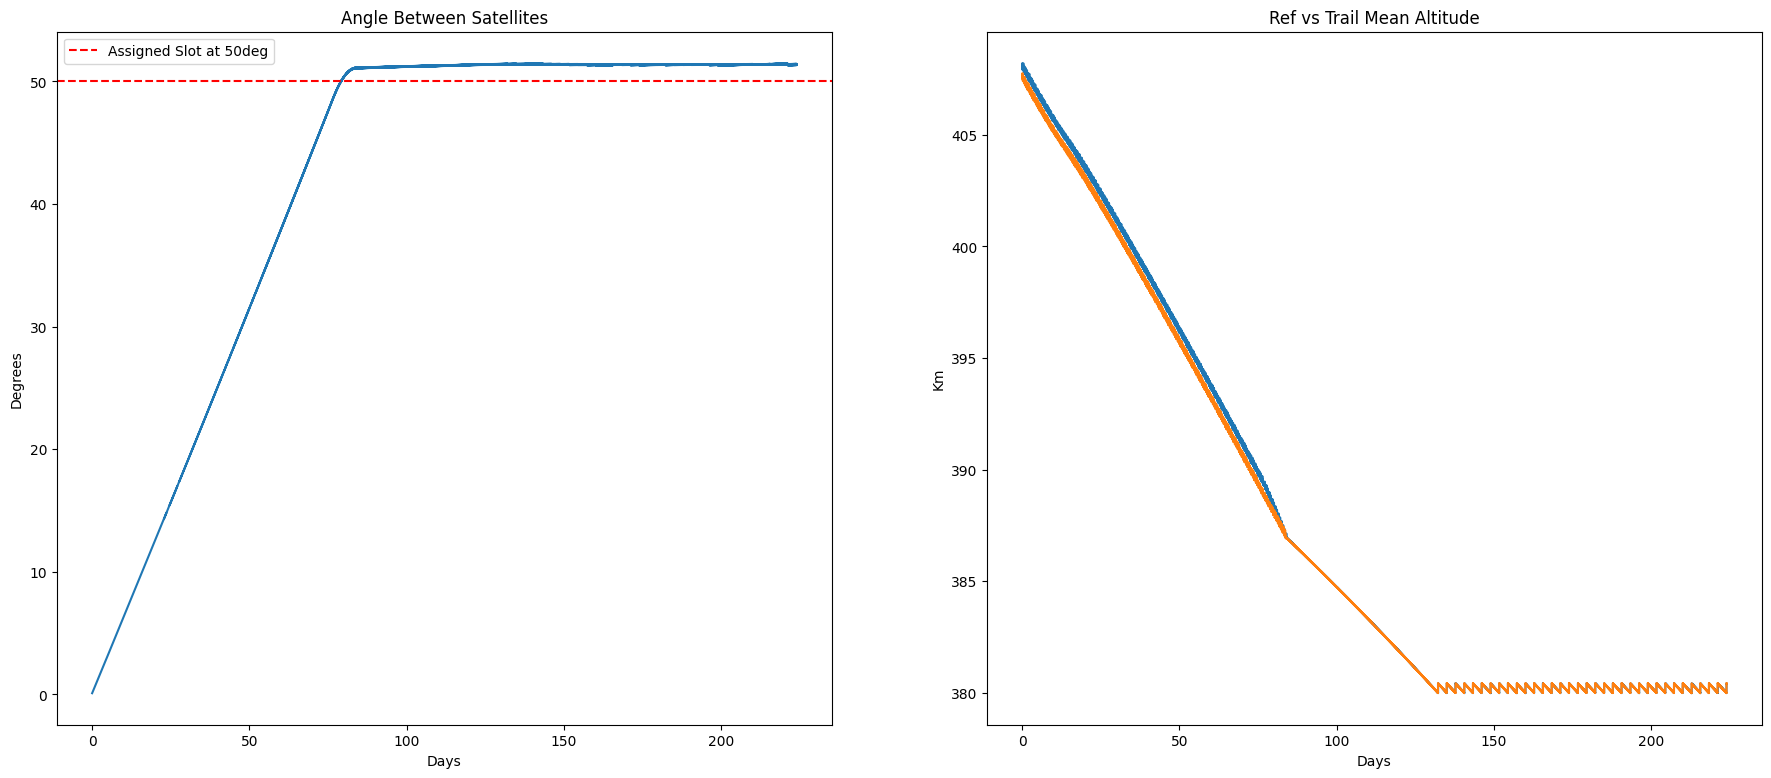

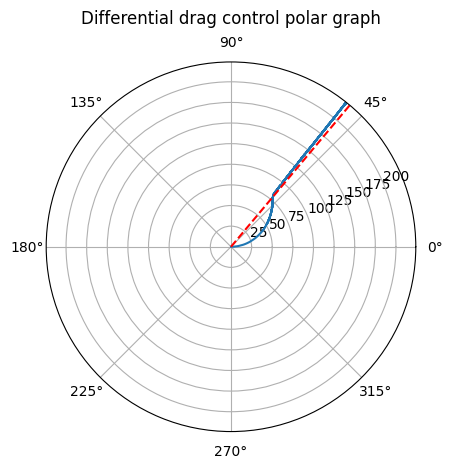

In [11]:
## DDIFFERENTIAL DRAG ALGORITHM BASED ON FOSTER THEORY

import time

import numpy as np

import matplotlib.pyplot as plt
from poliastro.plotting import OrbitPlotter3D

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.constants import R_earth
from poliastro.twobody.thrust import change_a_inc
from poliastro.core.propagation import func_twobody 
from poliastro.core.perturbations import J2_perturbation
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from osc2mean_dd import osc2mean
from sso_inc import inc_from_alt, raan_from_ltan, argl_difference
from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high, coesa76_model

toc = time.time()

## Input parameters
h = 410
delta_a = 0.5
delta_nu = -0.1
assignment = 50%360

# Earth Constants
R = Earth.R_mean.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2)
k_val = k.value
J2 = Earth.J2.value

## Orbital data
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

# Station Keeping 
a_up   = (R + 380.015)<<u.km
a_down = (R + 379.985)<<u.km 
inc_up = inc_from_alt(380,ecc)[0] << u.deg
inc_down = inc_from_alt(380,ecc)[0] << u.deg


# Satellite
C_D = 2.2
A   = 0.207 * u.m**2
m   = 50 * u.kg 
A_over_m = (A / m).to_value(u.km**2 / u.kg)   # km**2/kg
B = C_D * A_over_m   # ballistic coefficient at low drag mode
# SRP area = 0.805

# Thruster
T  = 0.007 * (u.kg * (u.m/u.s**2))
acc = (T/m).to(u.km/u.s**2)

## 2. ACCELERATION FUNCTIONS

def a_d(t0, state, k, J2, R, C_D, A_over_m):

    return J2_perturbation(
        t0, state, k, J2, R
        ) + coesa76_model(
            state, R, C_D, A_over_m
            )

a_d_thrust, deltaV, t_f = change_a_inc(k, a_down, a_up, inc_down, inc_up, acc)

def f_thrust(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0, 
        state, 
        k=k_val,
        J2=J2, 
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    ax_t, ay_t, az_t = a_d_thrust(t0,
                                  state,
                                  k=k)
    
    du_ad = np.array([0, 0, 0, ax+ax_t, ay+ay_t, az+az_t])

    return du_kep + du_ad

def f_no_thrust(t0, state, k):

    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0, 
        state, 
        k=k_val,
        J2=J2, 
        R = R, 
        C_D = C_D, 
        A_over_m = A_over_m
        )
    
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad



reference_orbit_0 = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc.to(u.rad),
    raan.to(u.rad),
    argp.to(u.rad),
    nu.to(u.rad),
    epoch
    )
trailing_orbit_0 = Orbit.from_classical(
    Earth,
    (a.value+delta_a)<<u.km,
    ecc,
    inc.to(u.rad),
    raan.to(u.rad),
    argp.to(u.rad),
    ((nu.value+delta_nu)<<u.deg).to(u.rad),
    epoch
    )

reference_orbit = reference_orbit_0
trailing_orbit = trailing_orbit_0

## Propagation data
time_step = 864<<u.s
pred_days = (assignment-delta_nu)

refsmalist = []
refsmalist_mean = []
trailsmalist = []
trailsmalist_mean = []

elapsedsecs = []
secs = 0
angle_list = []
hd_window = []
hd_duration = []

start_date_prop = epoch
ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
trail_mean = osc2mean(a.value+delta_a, ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu)
trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu<<u.deg), epoch)
mans = 1


## Differential drag algorithm + propagation
for i in range(mans):

    theta_err = (assignment - argl_difference(reference_orbit.argp.value, reference_orbit.nu.value, trailing_orbit.argp.value, trailing_orbit.nu.value))%360

    for attempts in range(2):
    
        tra_orb_pred_high = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))       
        tra_pred_mean_high = osc2mean(tra_orb_pred_high.a.value, tra_orb_pred_high.ecc.value, tra_orb_pred_high.inc.to_value(u.deg), tra_orb_pred_high.raan.to_value(u.deg), tra_orb_pred_high.argp.to_value(u.deg), tra_orb_pred_high.nu.to_value(u.deg))
        tra_orb_pred_mean_high = Orbit.from_classical(Earth, tra_pred_mean_high[0]<<u.km, tra_pred_mean_high[1]<<u.one, tra_pred_mean_high[2]<<u.deg, tra_pred_mean_high[3]<<u.deg, tra_pred_mean_high[4]<<u.deg, tra_orb_pred_high.nu.to(u.deg), tra_orb_pred_high.epoch)

        tra_orb_pred_low = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
        tra_pred_mean_low = osc2mean(tra_orb_pred_low.a.value, tra_orb_pred_low.ecc.value, tra_orb_pred_low.inc.to_value(u.deg), tra_orb_pred_low.raan.to_value(u.deg), tra_orb_pred_low.argp.to_value(u.deg), tra_orb_pred_low.nu.to_value(u.deg))
        tra_orb_pred_mean_low = Orbit.from_classical(Earth, tra_pred_mean_low[0]<<u.km, tra_pred_mean_low[1]<<u.one, tra_pred_mean_low[2]<<u.deg, tra_pred_mean_low[3]<<u.deg, tra_pred_mean_low[4]<<u.deg, tra_orb_pred_low.nu.to(u.deg), tra_orb_pred_low.epoch)

        theta_dot_dot = (tra_orb_pred_mean_high.n.to(u.deg/u.s) - tra_orb_pred_mean_low.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)  
        t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
        theta_hd = 0.5 * theta_dot_dot * t_hd**2
        t_wait = ((theta_err - theta_hd.value)%360 / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s)))

        pred_days = ((t_wait+t_hd.value)/(60*60*24))**(1+((trail_mean_orbit.a.value-Earth.R_mean.to_value(u.km)+(trail_mean_orbit.a.value-ref_mean_orbit.a.value))/(trail_mean_orbit.a.value + ref_mean_orbit.a.value)))

    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))

    hd_window.append((secs+t_wait)/(60*60*24))
    hd_duration.append(t_hd.to(u.day))


    for t in range(len(tofs_wait)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        refsmalist.append(ref_from_ephem.a.value)
        trailsmalist.append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean.append(trail_mean[0])
        
        angle_list.append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))

        elapsedsecs.append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    num_hd = int(t_hd.value / time_step.value)
    tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))


    for t in range(len(tofs_hd)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        refsmalist.append(ref_from_ephem.a.value)
        trailsmalist.append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean.append(trail_mean[0])
        
        angle_list.append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))

        elapsedsecs.append(secs)

    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    ref_mean = osc2mean(
        reference_orbit.a.value, 
        reference_orbit.ecc.value, 
        reference_orbit.inc.to_value(u.deg), 
        reference_orbit.raan.to_value(u.deg), 
        reference_orbit.argp.to_value(u.deg), 
        reference_orbit.nu.to_value(u.deg)
        )
    ref_mean_orbit = Orbit.from_classical(
                                          Earth, 
                                          ref_mean[0]<<u.km, 
                                          ref_mean[1]<<u.one, 
                                          ref_mean[2]<<u.deg, 
                                          ref_mean[3]<<u.deg, 
                                          ref_mean[4]<<u.deg, 
                                          reference_orbit.nu.to(u.deg), 
                                          reference_orbit.epoch
                                          )

    trail_mean = osc2mean(
        trailing_orbit.a.value, 
        trailing_orbit.ecc.value, 
        trailing_orbit.inc.to_value(u.deg), 
        trailing_orbit.raan.to_value(u.deg), 
        trailing_orbit.argp.to_value(u.deg), 
        trailing_orbit.nu.to_value(u.deg)
        )
    trail_mean_orbit = Orbit.from_classical(
                                            Earth, 
                                            trail_mean[0]<<u.km, 
                                            trail_mean[1]<<u.one, 
                                            trail_mean[2]<<u.deg, 
                                            trail_mean[3]<<u.deg, 
                                            trail_mean[4]<<u.deg, 
                                            trailing_orbit.nu.to(u.deg), 
                                            trailing_orbit.epoch
                                            )

    start_date_prop = reference_orbit.epoch
    

## Propagation with station-keeping
reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

ref_mean = osc2mean(
    reference_orbit.a.value, 
    reference_orbit.ecc.value, 
    reference_orbit.inc.to_value(u.deg), 
    reference_orbit.raan.to_value(u.deg), 
    reference_orbit.argp.to_value(u.deg), 
    reference_orbit.nu.to_value(u.deg)
    )
ref_mean_orbit = Orbit.from_classical(
                                    Earth, 
                                    ref_mean[0]<<u.km, 
                                    ref_mean[1]<<u.one, 
                                    ref_mean[2]<<u.deg, 
                                    ref_mean[3]<<u.deg, 
                                    ref_mean[4]<<u.deg, 
                                    reference_orbit.nu.to(u.deg), 
                                    reference_orbit.epoch
                                    )

trail_mean = osc2mean(
    trailing_orbit.a.value, 
    trailing_orbit.ecc.value, 
    trailing_orbit.inc.to_value(u.deg), 
    trailing_orbit.raan.to_value(u.deg), 
    trailing_orbit.argp.to_value(u.deg), 
    trailing_orbit.nu.to_value(u.deg)
    )
trail_mean_orbit = Orbit.from_classical(
                                        Earth, 
                                        trail_mean[0]<<u.km, 
                                        trail_mean[1]<<u.one, 
                                        trail_mean[2]<<u.deg, 
                                        trail_mean[3]<<u.deg, 
                                        trail_mean[4]<<u.deg, 
                                        trailing_orbit.nu.to(u.deg), 
                                        trailing_orbit.epoch
                                        )

t_sk = (60*60*24*7*20)<<u.s

num_sk = int(t_sk.value / time_step.value)
tofs_sk = TimeDelta(np.linspace(0, t_sk, num=num_sk))

no_maneuver_ref = True
no_maneuver_trail = True

for t in range(len(tofs_sk)):
    secs += time_step.value

    if  ref_mean[0] > a_down.value and no_maneuver_ref:
        reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_no_thrust))
    else:
        no_maneuver_ref = False
        reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_thrust))
        if ref_mean[0] > a_up.value:
            no_maneuver_ref = True

    if  trail_mean[0] > a_down.value and no_maneuver_trail:
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_no_thrust))
    else:
        no_maneuver_trail = False
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_thrust))
        if trail_mean[0] > a_up.value:
            no_maneuver_trail = True


    refsmalist.append(reference_orbit.a.value)
    trailsmalist.append(trailing_orbit.a.value)

    ref_mean = osc2mean(
        reference_orbit.a.value,
        reference_orbit.ecc.value,
        reference_orbit.inc.to_value(u.deg),
        reference_orbit.raan.to_value(u.deg),
        reference_orbit.argp.to_value(u.deg),
        reference_orbit.nu.to_value(u.deg)

    )
    trail_mean = osc2mean(
        trailing_orbit.a.value,
        trailing_orbit.ecc.value,
        trailing_orbit.inc.to_value(u.deg),
        trailing_orbit.raan.to_value(u.deg),
        trailing_orbit.argp.to_value(u.deg),
        trailing_orbit.nu.to_value(u.deg)
    )

    refsmalist_mean.append(ref_mean[0])
    trailsmalist_mean.append(trail_mean[0])
    
    angle_list.append(argl_difference(reference_orbit.argp.value, reference_orbit.nu.value, trailing_orbit.argp.value, trailing_orbit.nu.value))

    elapsedsecs.append(secs)



## Plots
# Agle between satellites + altitude variation
elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

trail_mean_altitudes = []
ref_mean_altitudes = []
for sma in range(len(trailsmalist_mean)):
    trail_mean_altitudes.append(trailsmalist_mean[sma] - Earth.R_mean.to_value(u.km))
    ref_mean_altitudes.append(refsmalist_mean[sma] - Earth.R_mean.to_value(u.km))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsed_days,trail_mean_altitudes,label='Trail')
ax[0,1].plot(elapsed_days,ref_mean_altitudes,label='Ref')
ax[0,1].set_title('Ref vs Trail Mean Altitude')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')


print(f'Starting HD windows time step [days]: {hd_window}')
print(f'HD windows duration [days]: {hd_duration}')

# Polar graph (angle between satellites)
radians = []
rad_assignment = []
for deg in range(len(angle_list)):
    radians.append(np.deg2rad(angle_list[deg]))
for deg in range(len(angle_list)):
    rad_assignment.append(np.deg2rad(assignment))

fig, pol = plt.subplots(subplot_kw={'projection': 'polar'})

pol.plot(radians, elapsed_days)
pol.plot(rad_assignment,elapsed_days,linestyle='--',color='red')
pol.set_rmax(elapsed_days[-1])
pol.grid(True)
pol.set_title("Differential drag control polar graph", va='bottom')

tic = time.time()
print(f't_wait = {t_wait}s\nt_hd = {t_hd.value}s')
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
print(angle_list[-1])
plt.show()

Starting HD windows time step [days]: [76.75531476628743]
HD windows duration [days]: [<Quantity 7.32524252 d>]
t_wait = 6631659.195807233s
t_hd = 632900.9537629643s
Timestep 864.0000 ss
Run time 1853.20s/30.89m
12.162875955295675


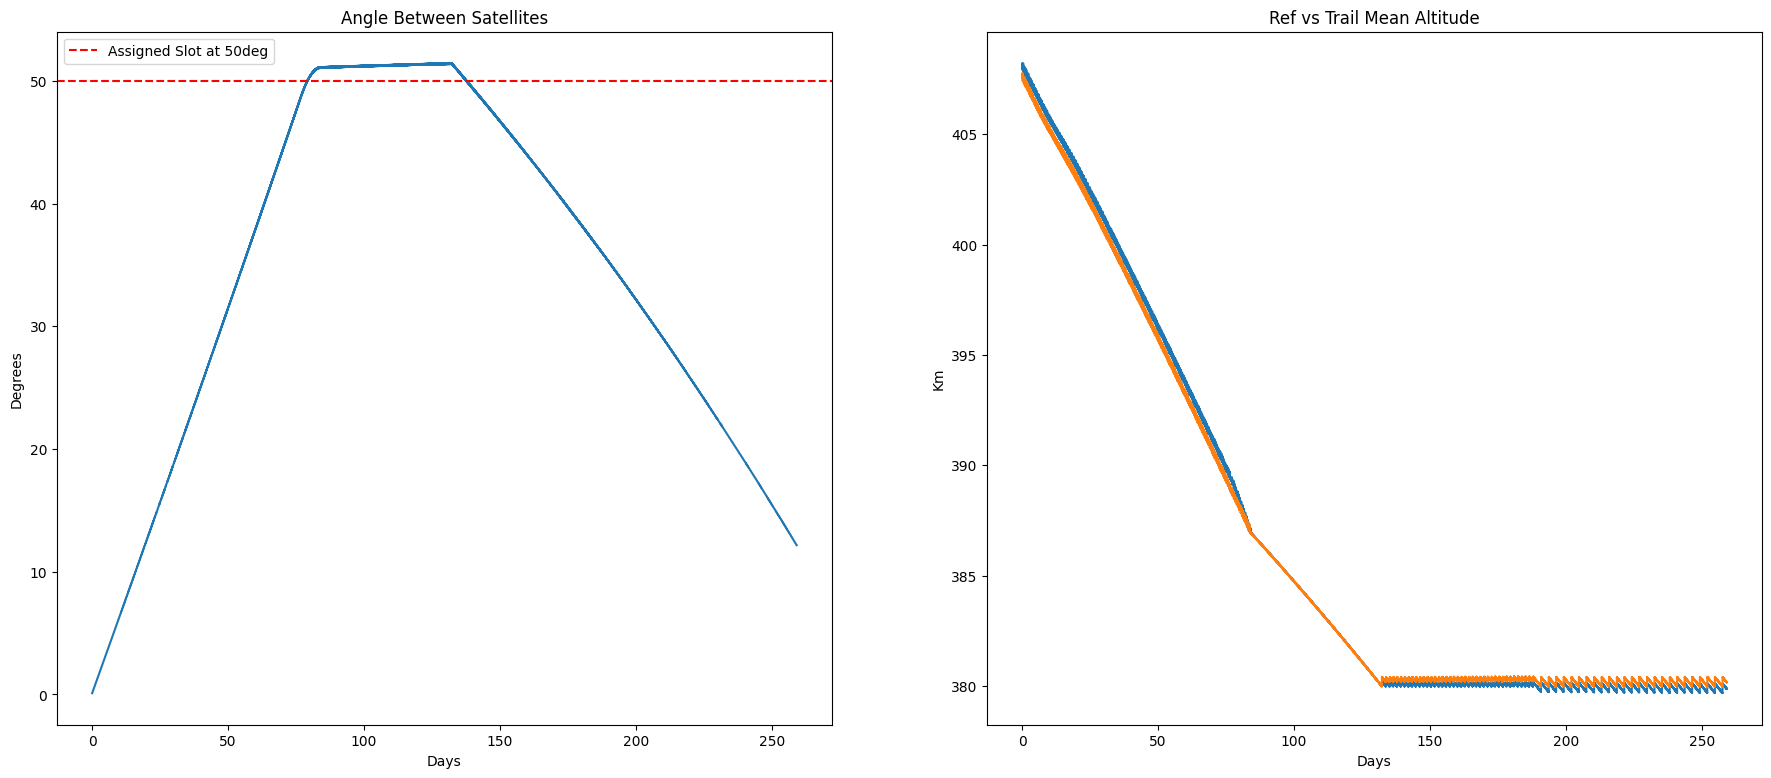

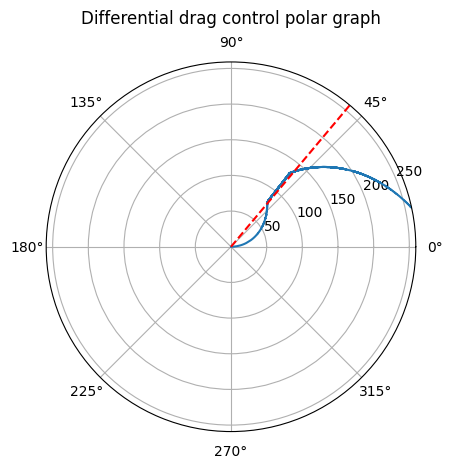

In [8]:
## Propagation with station-keeping

t_sk = (60*60*24*7*10)<<u.s

num_sk = int(t_sk.value / time_step.value)
tofs_sk = TimeDelta(np.linspace(0, t_sk, num=num_sk))

no_maneuver = True

for t in range(len(tofs_sk)):
    secs += time_step.value

    if  ref_mean[0] > a_down.value and no_maneuver:
        reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_no_thrust))
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_no_thrust))
    else:
        no_maneuver = False
        reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_thrust))
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_thrust))
        if ref_mean[0] > a_up.value:
            no_maneuver = True

    # if  trail_mean[0] > a_down.value and no_maneuver:
    #     trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_no_thrust))
    # else:
    #     no_maneuver = False
    #     trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f_thrust))
    #     if trail_mean[0] > a_up.value:
    #         no_maneuver = True


    refsmalist.append(reference_orbit.a.value)
    trailsmalist.append(trailing_orbit.a.value)

    ref_mean = osc2mean(
        reference_orbit.a.value,
        reference_orbit.ecc.value,
        reference_orbit.inc.to_value(u.deg),
        reference_orbit.raan.to_value(u.deg),
        reference_orbit.argp.to_value(u.deg),
        reference_orbit.nu.to_value(u.deg)

    )
    trail_mean = osc2mean(
        trailing_orbit.a.value,
        trailing_orbit.ecc.value,
        trailing_orbit.inc.to_value(u.deg),
        trailing_orbit.raan.to_value(u.deg),
        trailing_orbit.argp.to_value(u.deg),
        trailing_orbit.nu.to_value(u.deg)
    )

    refsmalist_mean.append(ref_mean[0])
    trailsmalist_mean.append(trail_mean[0])
    
    angle_list.append(argl_difference(reference_orbit.argp.value, reference_orbit.nu.value, trailing_orbit.argp.value, trailing_orbit.nu.value))

    elapsedsecs.append(secs)



## Plots
# Agle between satellites + altitude variation
elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

trail_mean_altitudes = []
ref_mean_altitudes = []
for sma in range(len(trailsmalist_mean)):
    trail_mean_altitudes.append(trailsmalist_mean[sma] - Earth.R_mean.to_value(u.km))
    ref_mean_altitudes.append(refsmalist_mean[sma] - Earth.R_mean.to_value(u.km))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsed_days,trail_mean_altitudes,label='Trail')
ax[0,1].plot(elapsed_days,ref_mean_altitudes,label='Ref')
ax[0,1].set_title('Ref vs Trail Mean Altitude')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')


print(f'Starting HD windows time step [days]: {hd_window}')
print(f'HD windows duration [days]: {hd_duration}')

# Polar graph (angle between satellites)
radians = []
rad_assignment = []
for deg in range(len(angle_list)):
    radians.append(np.deg2rad(angle_list[deg]))
for deg in range(len(angle_list)):
    rad_assignment.append(np.deg2rad(assignment))

fig, pol = plt.subplots(subplot_kw={'projection': 'polar'})

pol.plot(radians, elapsed_days)
pol.plot(rad_assignment,elapsed_days,linestyle='--',color='red')
pol.set_rmax(elapsed_days[-1])
pol.grid(True)
pol.set_title("Differential drag control polar graph", va='bottom')

tic = time.time()
print(f't_wait = {t_wait}s\nt_hd = {t_hd.value}s')
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
print(angle_list[-1])
plt.show()